### Import modules

First of all, we'll import all useful modules to our notebook.

In [1]:
#Import modules
%matplotlib inline

#handling data
import pandas as pd
import numpy as np

#import twitter credentials
from twitter_credentials import *

#handling information
import re
import json

#handling plots
import matplotlib.pyplot as plt

#for network creation
import networkx as nx

### Read json to DataFrame

The information that we've collected is stored in the file 'tweets.txt'. Because this file has a JSON format, we'll take advantage of the `read_json` function of the pandas module. 

In [2]:
# Read json into a pandas dataframe
tweets_df = pd.read_json("tweets.txt", lines=True)

According to [Twitter API website](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object), the Tweet object retrieved, provided in JSON format, has a long list of mixed `root-level` attributes, including basic information such as `id`, `created_at`, and `text`. Tweet objects are also the `parent` object to several child objects. Tweet child objects include `user`, `entities`, and extended_entities.

In order to have a better idea of the information we are dealing with, let's take a look at the `DataFrame` columns.

In [3]:
# Let's check the name of the columns
tweets_df.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'extended_tweet', 'favorite_count',
       'favorited', 'filter_level', 'geo', 'id', 'id_str',
       'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place',
       'possibly_sensitive', 'quote_count', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'reply_count', 'retweet_count', 'retweeted', 'retweeted_status',
       'source', 'text', 'timestamp_ms', 'truncated', 'user'],
      dtype='object')

From the displayed columns, we can observe some of them that look interesting for our future analysis. If we look more in detail, certain columns, such as `retweeted_status`, `entities` provide us with information about interactions regarding user mentions and user retweets. So, we are going to create a new `DataFrame` where to store all this important information that will come in handy when we build our Network. 

In [4]:
# Create a second dataframe to put important information
tweets_final = pd.DataFrame(columns = ["created_at", "id", "in_reply_to_screen_name", "in_reply_to_status_id", "in_reply_to_user_id",
                                      "retweeted_id", "retweeted_screen_name", "user_mentions_screen_name", "user_mentions_id", 
                                       "text", "user_id", "screen_name", "followers_count"])

In [5]:
# Columns that are going to be the same
equal_columns = ["created_at", "id", "text"]
tweets_final[equal_columns] = tweets_df[equal_columns]

Now, we need to obtain important information.

In [6]:
# Get the basic information about user 
def get_basics(tweets_final):
    tweets_final["screen_name"] = tweets_df["user"].apply(lambda x: x["screen_name"])
    tweets_final["user_id"] = tweets_df["user"].apply(lambda x: x["id"])
    tweets_final["followers_count"] = tweets_df["user"].apply(lambda x: x["followers_count"])
    return tweets_final

In [7]:
# Get the user mentions 
def get_usermentions(tweets_final):
    # Inside the tag 'entities' will find 'user mentions' and will get 'screen name' and 'id'
    tweets_final["user_mentions_screen_name"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["screen_name"] if x["user_mentions"] else np.nan)
    tweets_final["user_mentions_id"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["id_str"] if x["user_mentions"] else np.nan)
    return tweets_final

In [8]:
# Get retweets
def get_retweets(tweets_final):
    # Inside the tag 'retweeted_status' will find 'user' and will get 'screen name' and 'id'    
    tweets_final["retweeted_screen_name"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["screen_name"] if x is not np.nan else np.nan)
    tweets_final["retweeted_id"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["id_str"] if x is not np.nan else np.nan)
    return tweets_final

In [9]:
# Get the information about replies
def get_in_reply(tweets_final):
    # Just copy the 'in_reply' columns to the new dataframe
    tweets_final["in_reply_to_screen_name"] = tweets_df["in_reply_to_screen_name"]
    tweets_final["in_reply_to_status_id"] = tweets_df["in_reply_to_status_id"]
    tweets_final["in_reply_to_user_id"] = tweets_df["in_reply_to_user_id_str"]
    return tweets_final

In [10]:
# Lastly fill the new dataframe with the important information
def fill_df(tweets_final):
    get_basics(tweets_final)
    get_usermentions(tweets_final)
    get_retweets(tweets_final)
    get_in_reply(tweets_final)
    tweets_final.fillna(value=0, inplace=True)
    return tweets_final

In [11]:
# Get the interactions between the different users
def get_interactions(row):
    # From every row of the original dataframe
    # First we obtain the 'user_id' and 'screen_name'
    user = row["user_id"], row["screen_name"]
    # Be careful if there is no user id
    if user[0] == 0:
        return (None, None), []
    
    # The interactions are going to be a set of tuples
    interactions = set()
    
    # Add all interactions 
    # First, we add the interactions corresponding to replies adding the id and screen_name
    interactions.add((row["in_reply_to_user_id"], row["in_reply_to_screen_name"]))
    # After that, we add the interactions with retweets
    interactions.add((row["retweeted_id"], row["retweeted_screen_name"]))
    # And later, the interactions with user mentions
    interactions.add((row["user_mentions_id"], row["user_mentions_screen_name"]))
    
    # Discard if user id is in interactions
    interactions.discard((row["user_id"], row["screen_name"]))
    # Discard all not existing values
    interactions.discard((0.0, 0))
    interactions.discard((0.0, 0.0))
    # Return user and interactions
    return user, interactions

In [12]:
tweets_final = fill_df(tweets_final)

In [13]:
#tweets_final.head()

In [14]:
graph = nx.DiGraph()

In [15]:
for index, tweet in tweets_final.iterrows():
    user, interactions = get_interactions(tweet)
    user_id, user_name = user
    tweet_id = tweet["id"]
    for interaction in interactions:
        int_id, int_name = interaction
        graph.add_edge(user_id, int_id, tweet_id=tweet_id)
        
        graph.node[user_id]["name"] = user_name
        graph.node[int_id]["name"] = int_name       

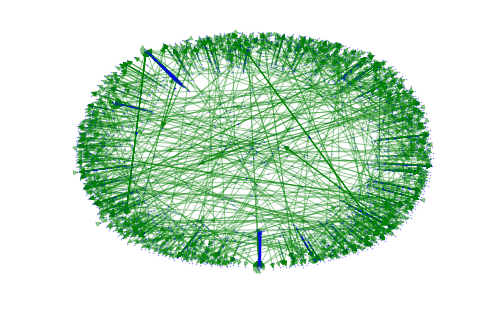

In [22]:
nx.draw(graph, node_color= "blue", node_size=0.3, node_shape='o', alpha=0.4, edge_color="green")